In [1]:
import numpy as np
import pandas as pd
from docx import Document 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
import lime
import lime.lime_tabular
import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("../working_data/dataset.csv", index_col=0)

In [3]:
df = df[df["Category"] != "Industrial Crops"]

## Creating working data frame

In [4]:
#df['Year'] = pd.to_datetime(df['Year'], format='%Y')
#df.set_index("Year", inplace=True)
# getting list of names
categories = df["Category"].unique()

## Creating the metrics data frame

In [5]:
lime_df = pd.DataFrame()

In [6]:
def table_to_doc(df, cat):
    doc = Document()
    doc.add_table(df.shape[0]+1, df.shape[1]+1)
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            df[column] = df[column].astype(float)
            df[column] = df[column].round(4)
    # Write the column headers
    for i, column_name in enumerate(df.columns):
        doc.tables[0].cell(0, i+1).text = column_name

    # Write the DataFrame values and index
    for i, row in enumerate(df.iterrows()):
        doc.tables[0].cell(i+1, 0).text = str(row[0])
        for j, value in enumerate(row[1]):
            doc.tables[0].cell(i+1, j+1).text = str(value)

    doc.save(f'../tables/rf_lime_{cat}.docx') 

## Random Forest Regression

### Setting up dataframe

#### - Solving for stationarity

In [7]:
imputer = KNNImputer(n_neighbors=4)
adf_df = pd.DataFrame(columns=df.columns)

for cate in categories: 
    # Selects category
    crop_df = df[df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    # Selects column for ADF Test
    for col in num_cols:
        if crop_df[col].count() < 5:
            continue
        adf_result = adfuller(crop_df[col])
        while adf_result[1] > 0.05:
            crop_df[col] = crop_df[col].diff()
            crop_df[num_cols.columns] = imputer.fit_transform(crop_df[num_cols.columns])
            adf_result = adfuller(crop_df[col])

    adf_df = pd.concat([adf_df, crop_df])

#### - Transforming time series data to supervised learning (adding lags to variables)

In [8]:
main_df = pd.DataFrame(columns=adf_df.columns)
imputer = KNNImputer(n_neighbors=4)

# Sliding Window
for cate in categories: 
    # Selects category
    crop_df = adf_df[adf_df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    for col in num_cols.columns:   
        for i in range(1, 3):
            crop_df[f'{col}-{i}'] = crop_df[col].shift(i)

    main_df = pd.concat([main_df, crop_df])
    num_cols = main_df.select_dtypes(include=[np.number])
    main_df[num_cols.columns] = imputer.fit_transform(main_df[num_cols.columns])

## Running the model

Intercept -3.9370709127371732
Prediction_local [81.45046536]
Right: 171.8441767500001


,Features Vegetables and Legumes,Coeffcients - Vegetables and Legumes
0,Summer > 0.00,48.040544
1,Mean CO2 (ppm) <= 0.00,13.972327
2,Yield (tonnes/ha)-1 > 0.35,13.050280
3,Mean CO2 (ppm)-1 <= 0.00,6.266794
4,Snow <= 0.49,-3.747084
5,Spring <= 0.00,-3.672174
6,Hail-1 <= 0.49,3.309607
7,Year-Round <= 0.00,3.101521
8,Total <= 0.49,2.731024
9,Wind-1 <= 0.49,2.334697


Intercept -1.9738555881213717
Prediction_local [0.96251163]
Right: 1.3639027499999974


,Features Cereals,Coeffcients - Cereals
0,Mean CO2 (ppm)-2 <= 0.00,2.633203
1,Mean CO2 (ppm)-1 <= 0.00,-1.054472
2,Mean CO2 (ppm) <= 0.00,0.961847
3,0.54 < Yield (tonnes/ha)-1 <= 0.66,0.340757
4,Summer <= 0.00,-0.266817
5,0.54 < Yield (tonnes/ha)-2 <= 0.66,0.216384
6,Devil-1 <= 0.50,-0.128128
7,0.00 < Fall <= 1.00,0.115426
8,Precip-2 <= 0.48,0.059145
9,Hail-2 <= 0.49,0.059022


Intercept 11.546536778941123
Prediction_local [9.33456135]
Right: 7.392740750000026


,Features Fruits and Nuts,Coeffcients - Fruits and Nuts
0,Mean CO2 (ppm) <= 0.00,-4.234286
1,Fall <= 0.00,2.853966
2,Mean CO2 (ppm)-1 <= 0.00,1.594235
3,0.00 < Spring <= 1.00,-1.513005
4,Tornado-2 <= 0.50,-1.024019
5,Hail-2 <= 0.49,-0.483215
6,Devil-2 <= 0.50,0.356827
7,Precip-2 <= 0.49,-0.347779
8,Snow-2 <= 0.49,0.300971
9,Year-Round <= 0.00,0.284329


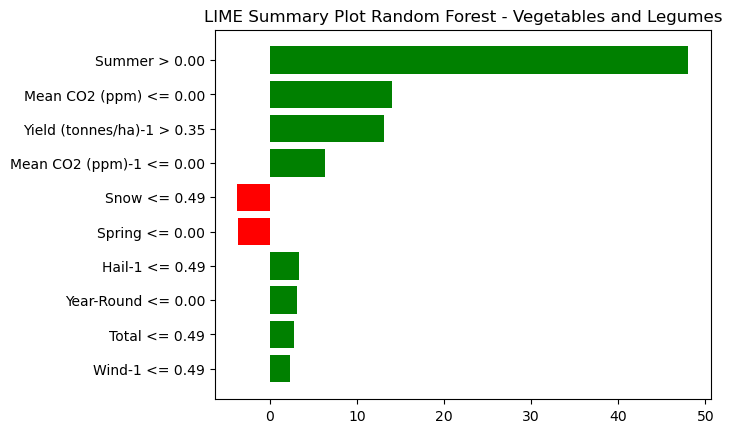

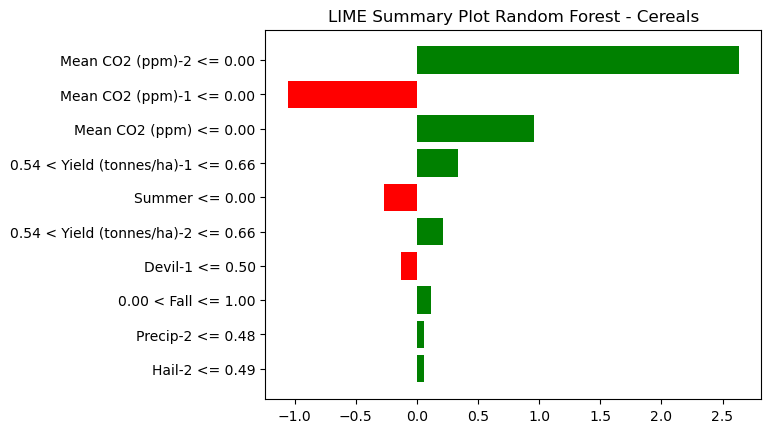

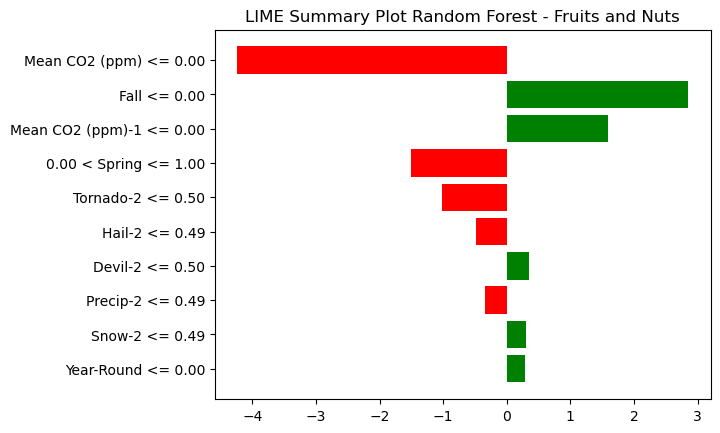

In [9]:
scaler = MinMaxScaler()
for cat in categories:
   crop_df = main_df[main_df['Category'] == cat]
   encoded_df = pd.get_dummies(crop_df[["Season"]], prefix='', prefix_sep='')
   encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)

   y = crop_df[['Yield (tonnes/ha)']]
   x = crop_df.drop(['Yield (tonnes/ha)', "Item", "Category", "Season"], axis=1)
   x = pd.concat([x, encoded_df], axis=1)

   mean = x.mean()
   std = x.std()
   lower_bound = mean - 2 * std
   upper_bound = mean + 2 * std
   x = x.clip(lower_bound, upper_bound, axis=1)

   x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
   
   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=42)
   regressor = RandomForestRegressor(n_estimators = 400, random_state = 42)
   regressor.fit(x_train, y_train)
   
   #prediction of new value
   y_pred = regressor.predict(x_test)

   #lime implementation
   explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train),
                  feature_names=x_train.columns, verbose=True,
                  class_names=['Yield(tonnes/ha)'], mode='regression')
   exp = explainer.explain_instance(x_test.iloc[-1], regressor.predict, num_features=10)
   
   exp.as_pyplot_figure()
   plt.title("LIME Summary Plot Random Forest - " + cat)
   
   lime_res = pd.DataFrame(exp.as_list(),  columns=['Features ' + cat, 'Coeffcients - ' + cat])
   display(lime_res)
   table_to_doc(lime_res, cat)